## Identifying Entities in Healthcare Data

### **Problem Statement**  
In the healthcare industry, large amounts of unstructured text data are generated daily, including doctors note, patient records and therapy reviews. Extracting meaningful insights from this data is challenging due to the use of complex medical terminology. An important aspect is the mapping of diseases for their related treatments, which are necessary for medical research, decision making and care of the patient.

Currently, this information is buried within free-text data, making it difficult for non-medical professionals to explain. Given a dataset containing medical text, the goal is to automatically remove the name of the disease and their affiliated treatments and present them in a structured format (such as a table or dictionary).

To achieve this, there is a need to develop a **custom Named Entity Recognition (NER) model** to accurately identify and classify diseases and their related treatments within the dataset.

---

### **Objectives**  
1. **Develop a Custom NER Model**: Train a Named Entity Recognition (NER) model to extract disease names and their respective remedies from unstructured medical text.  
2. **Automate Disease-Treatment Mapping**: Apply an algorithm to associate each identified disease with its probable treatment based on contextual information.   Apply an algorithm to connect each identified disease with its potential treatment based on relevant information. 
3. **Create a Structured Representation**: Store the extracted disease-treatment pairs in an easily accessible format such as a dictionary or table.  
4. **Improve Accuracy and Performance**: Adapt the NER model using domain-specific techniques like transfer learning, entity linking and fine-tuning with medical dataset.
5. **Enable Scalability and Usability**: Design solutions to handle large versions of medical texts efficiently and make sure it can be integrated into existing healthcare platforms.  
6. **Evaluate the Model**: To ensure its reliability for medical text processing, assess the performance of the model using matrix like accurate, recall and F1-score.


### **Steps to Solve the Problem**  

To effectively extract diseases and their corresponding treatments from medical text, follow these structured steps:  

---

#### **Step 1: Data Understanding and Preprocessing**  
- **Explore the dataset** (Train Sentence, Train Label, Test Sentence, Test Label) to understand how diseases and treatments are represented in text.  
- **Clean the text data** by removing special characters, stopwords (if needed), and ensuring proper tokenization.  
- **Standardize medical terms** using medical ontologies like UMLS or SNOMED CT to handle variations in terminology (e.g., "chemotherapy" vs. "chemo").  

---

#### **Step 2: Annotate Data for Named Entity Recognition (NER)**  
- **Identify and label entities** in the dataset manually (if not already labeled). Entities include:  
  - **Diseases** (e.g., "lung cancer")  
  - **Treatments** (e.g., "chemotherapy", "radiation therapy")  
- **Format annotations** in BIO (Begin, Inside, Outside) tagging scheme for training the NER model.  

---

#### **Step 3: Build and Evaluate a Custom NER Model**  
- **Choose an NLP framework** such as:  
  - **spaCy** (for custom rule-based and deep learning NER)  
  - **BERT-based models** (e.g., BioBERT, ClinicalBERT for medical text)  
  - **NLTK and SciSpacy** for preprocessing and entity recognition  
- **Train the model** on the annotated dataset to recognize disease-treatment pairs.  

---

#### **Step 4: Extract Disease-Treatment Mappings**  
- **Process unseen medical text** and extract entities using the trained model.  
- **Map extracted treatments to diseases** based on sentence context.  
- **Store results** in a structured format, such as:  
  ```python
  disease_treatment_mapping = {
      "lung cancer": ["chemotherapy", "radiation therapy"],
      "diabetes": ["insulin therapy", "metformin"],
      ...
  }
  ```  
- Convert the extracted data into a **tabular format**:  

| **KEY (Disease)**  | **VALUE (Treatments)**  |  
|-------------------|---------------------|  
| Disease_1 (Lung Cancer) | chemotherapy, radiation therapy |  
| Disease_2 (Diabetes) | insulin therapy, metformin |  
| Disease_3 (Hypertension) | beta-blockers, ACE inhibitors |  

---
#### **Step 5: Evaluate the Model Performance**  
- Use **evaluation metrics** such as:  
  - **Precision, Recall, and F1-score** to measure NER accuracy.  
  - **Confusion matrix** to identify misclassifications.  
- Compare results with medical knowledge bases for validation.  

---

<div style="background-color: #1c1c1c; color: white; padding: 20px; font-size: 16px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
  <h2>Import and Installing Necessary Libraries</h2>
</div>

In [1]:
# Importing libraries
!pip install pycrf
!pip install sklearn-crfsuite

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import spacy
import textwrap
import warnings
import json
import sklearn_crfsuite
from sklearn_crfsuite import metrics, CRF
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix, roc_curve, auc, confusion_matrix, classification_report
from sklearn.preprocessing import MultiLabelBinarizer

warnings.filterwarnings("ignore")
model = spacy.load("en_core_web_sm")

In [2]:
# File Paths for accessing from local repository
train_sent_path = 'train_sent.csv'
train_label_path = 'train_label.csv'
test_sent_path = 'test_sent.csv'
test_label_path = 'test_label.csv'

In [3]:
def display_information(title, content, separator_length=100):
    """
    Function to print a labeled section with a separator line before and after the title and content.
    
    Parameters:
    title (str): The label or heading to display.
    content (str): The content to display under the title.
    separator_length (int, optional): The length of the separator line. Defaults to 100.
    """
    
    bold = "\033[1m"  # ANSI escape sequence for bold text
    reset = "\033[0m"  # Reset to normal text
 
    # Print a separator line of the specified length
    print("-" * separator_length)

    # Print the bold, centered title
    print(f"{bold}{title.center(separator_length)}{reset}")

    # Print another separator line of the specified length
    print("-" * separator_length)
    
    # Print the content (text) without centering or bold
    print(content)

In [4]:
# Load Dataset
with open(train_sent_path, 'r') as train_sent_file:
  train_sent = train_sent_file.readlines()

display_information("Train Sentence",train_sent[0:100])

with open(train_label_path, 'r') as train_labels_file:
  train_lab = train_labels_file.readlines()

display_information("Train Labels",train_lab[0:100])

with open(test_sent_path, 'r') as test_sent_file:
  test_sent = test_sent_file.readlines()

display_information("Test Sentence",test_sent[0:100])

with open(test_label_path, 'r') as test_labels_file:
  test_lab = test_labels_file.readlines()

display_information("Test Labels",test_lab[0:100])

----------------------------------------------------------------------------------------------------
                                           Train Sentence                                           
----------------------------------------------------------------------------------------------------
['All\n', 'live\n', 'births\n', '>\n', 'or\n', '=\n', '23\n', 'weeks\n', 'at\n', 'the\n', 'University\n', 'of\n', 'Vermont\n', 'in\n', '1995\n', '(\n', 'n\n', '=\n', '2395\n', ')\n', 'were\n', 'retrospectively\n', 'analyzed\n', 'for\n', 'delivery\n', 'route\n', ',\n', 'indication\n', 'for\n', 'cesarean\n', ',\n', 'gestational\n', 'age\n', ',\n', 'parity\n', ',\n', 'and\n', 'practice\n', 'group\n', '(\n', 'to\n', 'reflect\n', 'risk\n', 'status\n', ')\n', '\n', 'The\n', 'total\n', 'cesarean\n', 'rate\n', 'was\n', '14.4\n', '%\n', '(\n', '344\n', 'of\n', '2395\n', ')\n', ',\n', 'and\n', 'the\n', 'primary\n', 'rate\n', 'was\n', '11.4\n', '%\n', '(\n', '244\n', 'of\n', '2144\n', ')\n', '\n', '

<div style="background-color: #1c1c1c; color: white; padding: 20px; font-size: 16px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
  <h2>Data Understanding and Preprocessing</h2>
  <p>The dataset provided is in the form of one word per line. Let's understand the format of data below:</p>
  <ul>
    <li>Suppose there are <em>x</em> words in a sentence, then there will be <em>x</em> continuous lines with one word in each line.</li>
    <li>Further, the two sentences are separated by empty lines. The labels for the data follow the same format.</li>
  </ul>
  <p><strong>We need to pre-process the data to recover the complete sentences and their labels.</strong></p>
</div>

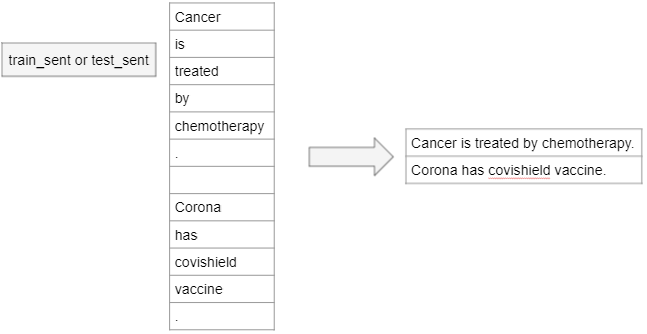

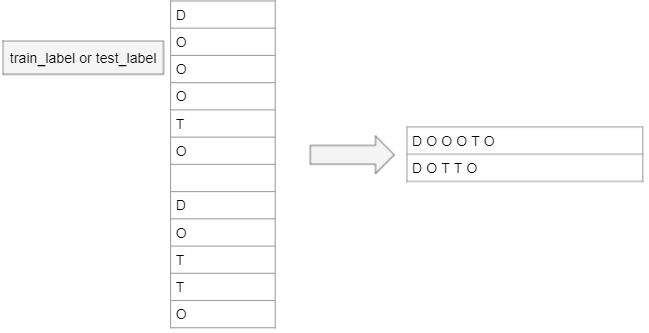

In [5]:
# Function to read the file and construct sentences from individual words
def read_file(file_name):
    # Open the file with UTF-8 encoding and read all lines
    with open(file_name, 'r', encoding='utf-8') as file:
        content = file.readlines()  # Read all lines from the file
    
    # Initialize variables for sentences, current sentence, and word count
    sentences = []  # List to store all the sentences
    sentence = ""  # Variable to accumulate words for the current sentence
    word_count = 0  # Counter for the total number of words
    
    # Loop through each word in the content
    for word in content:
        word = word.strip('\n')  # Remove newline characters
        
        if word == "":
            # If an empty line is encountered, save the sentence and reset
            sentences.append(sentence.rstrip(" "))  # Remove any trailing space
            sentence = ""  # Reset the current sentence
        else:
            word_count += 1  # Increment word count for each non-empty word
            sentence += word + " "  # Add the word to the current sentence
            
    # Append the last sentence if there's no newline at the end of the file
    if sentence:
        sentences.append(sentence.rstrip(" "))  # Add the last sentence
    
    # Print information about the content with proper formatting
    print("Number of Words     : ", word_count)
    print("Number of Sentences : ", len(sentences))
       
    # Print the 5 sentences (if they exist) in wrapped format
    for i in range(0, min(5, len(sentences))):
        # Text wrapper to ensure the sentence fits within a certain width
        wrapper = textwrap.TextWrapper(initial_indent="Sentence {0}          :  ".format(i+1), width=150)
        print(wrapper.fill(sentences[i]))  # Print the wrapped sentence
    
    return sentences  # Return the list of sentences

# POS Tagging and Visualization Function
def visualize_pos_tags(sentence):
    """Visualizes POS tags using Spacy displaCy."""
    print("\n")
    doc = model(sentence)
    spacy.displacy.render(doc, style="dep", jupyter=True, options={"compact": True, "page": False})

### Count the Sentences
Count the sentences in both processed train and test dataset, then print five sentences before each dataset. This provides a brief observation of the structure of the data showing a sample of sentences from both datasets for further analysis or verification. Also displays the POS tagging visualization for the example sentence in both datasets.

In [6]:
display_information("Training Sentences","")
train_sentences = read_file(train_sent_path)
visualize_pos_tags(train_sentences[1].strip())
print("\n")
display_information("Test Sentences","")
test_sentences = read_file(test_sent_path)
visualize_pos_tags(test_sentences[1].strip())

----------------------------------------------------------------------------------------------------
                                         Training Sentences                                         
----------------------------------------------------------------------------------------------------

Number of Words     :  45902
Number of Sentences :  2599
Sentence 1          :  All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery
route , indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )
Sentence 2          :  The total cesarean rate was 14.4 % ( 344 of 2395 ) , and the primary rate was 11.4 % ( 244 of 2144 )
Sentence 3          :  Abnormal presentation was the most common indication ( 25.6 % , 88 of 344 )
Sentence 4          :  The `` corrected '' cesarean rate ( maternal-fetal medicine and transported patients excluded ) was 12.4 % ( 273 of 2194 ) ,
and the `` co



----------------------------------------------------------------------------------------------------
                                           Test Sentences                                           
----------------------------------------------------------------------------------------------------

Number of Words     :  18618
Number of Sentences :  1056
Sentence 1          :  Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks ,
the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )
Sentence 2          :  As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration
Sentence 3          :  The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period
Sentence 4          :  There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , w

### Count the Labels
Calculate the number of label lines in processed train and test dataset, then print five labels before each dataset. This provides a quick observation of label distribution in both datasets, providing a sample of the label for further examination or verification purposes.

In [7]:
display_information("Training Labels","")
train_labels = read_file(train_label_path)
print("\n")
display_information("Test Labels","")
test_labels = read_file(test_label_path)

----------------------------------------------------------------------------------------------------
                                          Training Labels                                           
----------------------------------------------------------------------------------------------------

Number of Words     :  45902
Number of Sentences :  2599
Sentence 1          :  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
Sentence 2          :  O O O O O O O O O O O O O O O O O O O O O O O O O
Sentence 3          :  O O O O O O O O O O O O O O O
Sentence 4          :  O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O
Sentence 5          :  O O O O O O O O O O O O O O O O O O O O O O


----------------------------------------------------------------------------------------------------
                                            Test Labels                                             
------------------------------

<div style="background-color: #1c1c1c; color: white; padding: 20px; font-size: 16px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
  <h2>Annotate Data for Named Entity Recognition (NER)</h2>
  <p>We will begin by identifying the various concepts present in the dataset using Part-of-Speech (PoS) tagging.</p>
  <p>Next, we will extract the tokens tagged as NOUN or PROPN and calculate their frequency.</p>
</div>

In [8]:
def get_pos_tags(reviews, labels, tag=""):
    """
    Function to extract Part-of-Speech (PoS) tags, lemmas, and tokens from text data.
    
    Parameters:
    - reviews (list): List of sentences or reviews.
    - labels (list): Corresponding labels for each review (e.g., categories or sentiments).
    - tag (str, optional): Prefix to be added to sentence numbering for identification. Default is an empty string.
    
    Returns:
    - sentence (list): List of sentence identifiers with prefix.
    - pos (list): List of PoS tags for each token.
    - lemma (list): List of lemmatized tokens.
    - text (list): List of original tokens.
    - label (list): List of labels corresponding to each token in the reviews.
    """

    # Lists to store tokenized sentence data
    sentence = []
    pos = []
    lemma = []
    text = []
    label = []
    
    i = 1  # Initialize sentence count
    
    # Iterate over reviews and labels
    for review, review_labels in tqdm(zip(reviews, labels)):
        
        # Iterate over each word in the review and corresponding label
        for doc, review_label in zip(review.split(), review_labels.split()):
            
            # Process each token (word) in the review using the model
            s = model(doc)
            
            # Loop through each token in the processed sentence (s)
            for tok in s:
                # Append sentence ID with a prefix (tag) and sentence number
                sentence.append(tag + str(i))
                
                # Append PoS tag for the token
                pos.append(tok.pos_)
                
                # Append lemmatized form of the token
                lemma.append(tok.lemma_)
                
                # Append original token (text) itself
                text.append(tok.text)
                
                # Append the corresponding label for the token
                label.append(review_label)
        
        i += 1  # Increment the sentence count
    
    # Return the processed data as separate lists
    return sentence, pos, lemma, text, label

In [9]:
# Process training data
train_sentence, train_pos, train_lemma, train_text, train_label = get_pos_tags(train_sentences, train_labels, "train_")

# Create DataFrame for training data with PoS, lemma, and labels
train_frequency_df = pd.DataFrame({
    'sentence': train_sentence, 
    'text': train_text, 
    'lemma': train_lemma, 
    'pos': train_pos, 
    'label': train_label
})

# Display information about the training sentences
display_information("Training Sentences", train_frequency_df.head())

print("\n")

# Process test data
test_sentence, test_pos, test_lemma, test_text, test_label = get_pos_tags(test_sentences, test_labels, "test_")

# Create DataFrame for test data with PoS, lemma, and labels
test_frequency_df = pd.DataFrame({
    'sentence': test_sentence, 
    'text': test_text, 
    'lemma': test_lemma, 
    'pos': test_pos, 
    'label': test_label
})

# Display information about the testing sentences
display_information("Testing Sentences", test_frequency_df.head())

2599it [03:27, 12.53it/s]


----------------------------------------------------------------------------------------------------
                                         Training Sentences                                         
----------------------------------------------------------------------------------------------------
  sentence    text  lemma    pos label
0  train_1     All    all    ADV     O
1  train_1    live   live    ADJ     O
2  train_1  births  birth   NOUN     O
3  train_1       >      >  PUNCT     O
4  train_1      or     or  CCONJ     O




1056it [01:24, 12.43it/s]

----------------------------------------------------------------------------------------------------
                                         Testing Sentences                                          
----------------------------------------------------------------------------------------------------
  sentence         text        lemma    pos label
0   test_1  Furthermore  furthermore    ADV     O
1   test_1            ,            ,  PUNCT     O
2   test_1         when         when  SCONJ     O
3   test_1          all          all   PRON     O
4   test_1   deliveries     delivery   NOUN     O


**Visualizing Entity Label Distribution**

The `plot_entity_distribution` function visualizes the distribution of entity labels in a given dataset. It generates a bar chart and a pie chart to display the frequency of each entity type. This helps in understanding the balance and prevalence of different entity labels within the dataset.

----------------------------------------------------------------------------------------------------
                                            Train Labels                                            
----------------------------------------------------------------------------------------------------



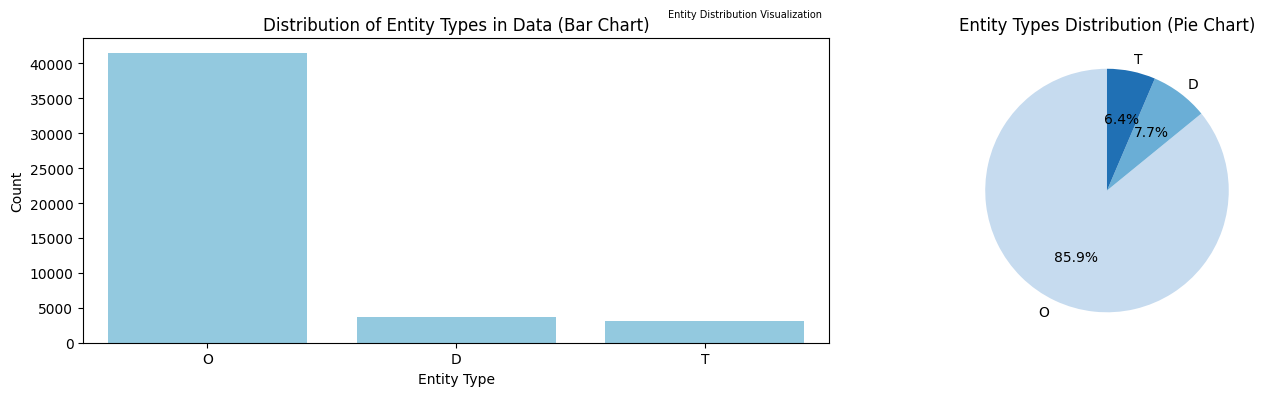

----------------------------------------------------------------------------------------------------
                                            Test Labels                                             
----------------------------------------------------------------------------------------------------



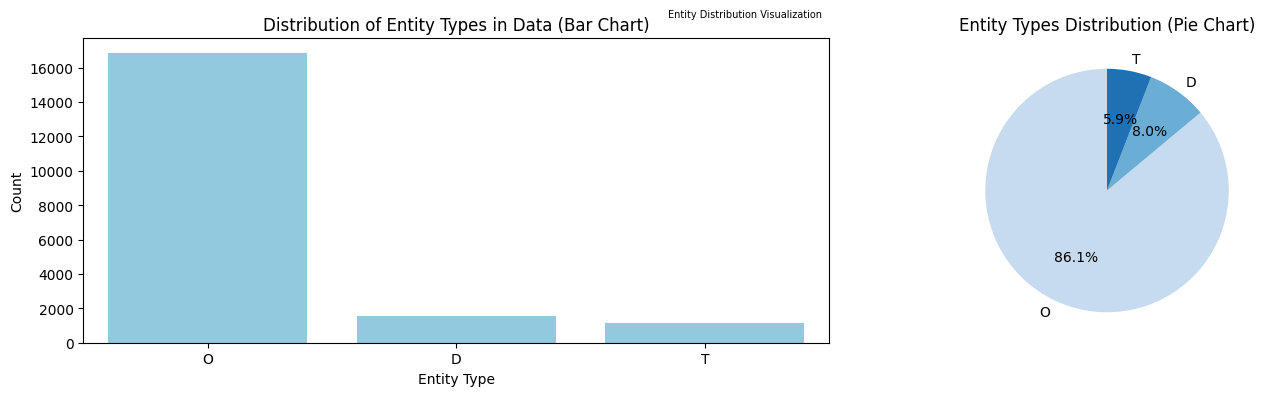

In [10]:
def plot_entity_distribution(df, label_column):
    """
    Function to plot the distribution of entity labels in the provided dataframe.
    
    Parameters:
    df (pandas.DataFrame): The DataFrame containing the data.
    label_column (str): The name of the column that contains the entity labels.
    
    Returns:
    None: Displays a bar and pie chart for entity distribution.
    """
    
    # Count the occurrences of each entity label in the specified column
    entity_counts = Counter(df[label_column])
    
    # Create a figure with a specific size
    plt.figure(figsize=(15, 4))
    
    # Plot the bar chart (1st subplot)
    plt.subplot(1, 2, 1)
    sns.barplot(x=list(entity_counts.keys()), y=list(entity_counts.values()), color='skyblue')
    plt.title("Distribution of Entity Types in Data (Bar Chart)")
    plt.xlabel("Entity Type")
    plt.ylabel("Count")
    
    # Plot the pie chart (2nd subplot)
    plt.subplot(1, 2, 2)
    plt.pie(list(entity_counts.values()), labels=list(entity_counts.keys()), autopct='%1.1f%%', 
            startangle=90, colors=sns.color_palette("Blues", len(entity_counts)))
    plt.title("Entity Types Distribution (Pie Chart)")
    
    # Adjust layout and display the overall title
    plt.tight_layout()
    plt.suptitle("Entity Distribution Visualization", fontsize=7)
    
    # Show the plot
    plt.show()

# Example usage (assuming 'train_frequency_df' is already defined):
display_information("Train Labels", "")
plot_entity_distribution(train_frequency_df, 'label')

display_information("Test Labels", "")
plot_entity_distribution(test_frequency_df, 'label')

In [11]:
# Concatenate the training and testing DataFrames to combine them into one dataset
frequency_df = pd.concat((train_frequency_df.copy(), test_frequency_df.copy()), axis=0)
frequency_df

,sentence,text,lemma,pos,label
0,train_1,All,all,ADV,O
1,train_1,live,live,ADJ,O
2,train_1,births,birth,NOUN,O
3,train_1,>,>,PUNCT,O
4,train_1,or,or,CCONJ,O
...,...,...,...,...,...
19578,test_1056,globulin,globulin,NOUN,T
19579,test_1056,for,for,ADP,O
19580,test_1056,recurrent,recurrent,NOUN,D
19581,test_1056,spontaneous,spontaneous,ADJ,D


**Visualizing Part-of-Speech (POS) Tags from the Dataset**

This function visualizes the distribution of Part-of-Speech (POS) tags in a given dataset. It generates a bar chart to show the frequency of each POS tag. Optionally, it can also display the syntactic structure of a sentence using `spaCy`'s displaCy visualization tool, providing insights into the grammatical relationships within the sentence.

----------------------------------------------------------------------------------------------------
                                     Train Sentences - PoS Tags                                     
----------------------------------------------------------------------------------------------------



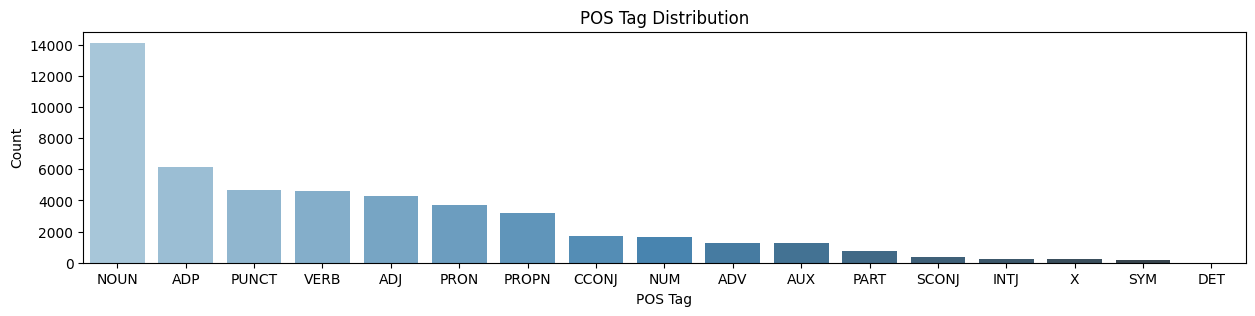

----------------------------------------------------------------------------------------------------
                                     Test Sentences - PoS Tags                                      
----------------------------------------------------------------------------------------------------



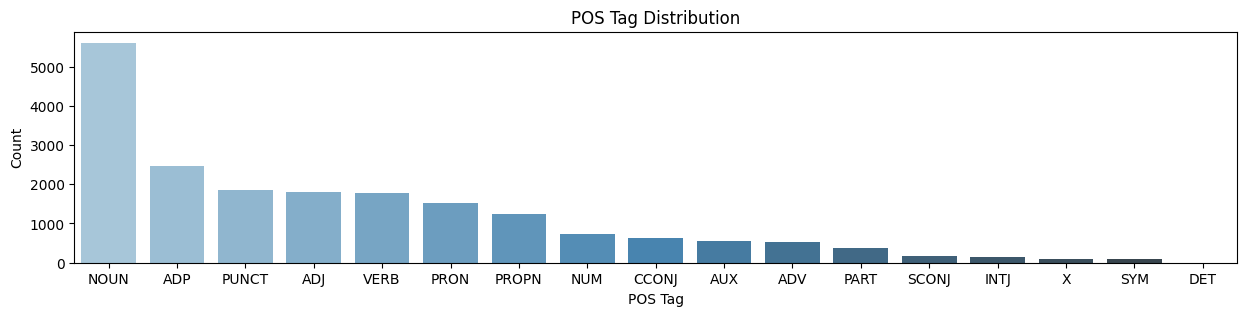

In [12]:
def visualize_pos_tags(df):
    """
    Visualizes the distribution of POS tags in the dataframe.
    
    Parameters:
    df (pandas.DataFrame): DataFrame containing POS tags to visualize.
    """
    # Count the occurrences of each POS tag
    pos_counts = df['pos'].value_counts()

    # Create a bar chart to visualize POS tag distribution
    plt.figure(figsize=(15, 3))
    sns.barplot(x=pos_counts.index, y=pos_counts.values, palette='Blues_d')
    plt.title("POS Tag Distribution")
    plt.xlabel("POS Tag")
    plt.ylabel("Count")
    plt.show()

# Visualize POS tags from the dataframe
display_information("Train Sentences - PoS Tags", "")
visualize_pos_tags(train_frequency_df)

display_information("Test Sentences - PoS Tags", "")
visualize_pos_tags(test_frequency_df)

### Top 25 Most Common Tokens with NOUN or PROPN PoS Tags

In this step, we will display the 25 most frequent tokens that are tagged as **NOUN** or **PROPN**. These tokens represent key concepts or proper nouns within the dataset, and identifying the most common ones will help us understand the primary subjects and entities present.

In [13]:
# Filter the dataframe to select rows where the PoS is either NOUN or PROPN
noun_propn_df = frequency_df[frequency_df['pos'].isin(['NOUN', 'PROPN'])]

# Get the top 25 most frequent text forms of nouns and proper nouns
top_25_tokens = noun_propn_df['text'].value_counts().head(25)

# Calculate the percentage for each token
top_25_tokens_percentage = round((top_25_tokens / top_25_tokens.sum()) * 100, 2)

# Combine the count and percentage into a DataFrame for better display
top_25_tokens_df = pd.DataFrame({
    'Count': top_25_tokens,
    'Percentage': top_25_tokens_percentage
})

# Display the result
display_information("Text", top_25_tokens_df)

# Get the top 25 most frequent lemma forms of nouns and proper nouns
top_25_lemmas = noun_propn_df['lemma'].value_counts().head(25)

# Calculate the percentage for each lemma
top_25_lemmas_percentage = round((top_25_lemmas / top_25_lemmas.sum()) * 100, 2)

# Combine the count and percentage into a DataFrame for better display
top_25_lemmas_df = pd.DataFrame({
    'Count': top_25_lemmas,
    'Percentage': top_25_lemmas_percentage
})

# Display the result
display_information("Lemma", top_25_lemmas_df)

----------------------------------------------------------------------------------------------------
                                                Text                                                
----------------------------------------------------------------------------------------------------
              Count  Percentage
text                           
patients        492       16.48
treatment       281        9.41
cancer          200        6.70
therapy         175        5.86
study           162        5.43
disease         143        4.79
cell            140        4.69
lung            116        3.89
group            94        3.15
chemotherapy     88        2.95
gene             88        2.95
effects          85        2.85
results          79        2.65
use              78        2.61
women            77        2.58
patient          75        2.51
surgery          71        2.38
risk             71        2.38
cases            71        2.38
analysis         70      

### Defining Features for CRF

We have defined the following features for building the CRF (Conditional Random Field) module:

    f1 = bias term; always set to 1.0
    f2 = lowercase version of the word
    f3 = first 3 characters of the word
    f4 = last 3 characters of the word
    f5 = 1 if the word is in lowercase; otherwise, 0
    f6 = 1 if the word is in uppercase; otherwise, 0
    f7 = 1 if the word starts with a capital letter (title case); otherwise, 0
    f8 = 1 if the word is a digit (number); otherwise, 0
    f9 = length of the word
    f10 = Part-of-Speech (PoS) tag of the word
    f11 = 1 if PoS tag of the word is Noun or Pronoun; otherwise, 0
    f12 = word shape, describing the capitalization pattern
    f13 = 1 if the word is alphanumeric (letters and/or digits); otherwise, 0
    f14 = 1 if the word consists entirely of punctuation characters; otherwise, 0

These features capture various linguistic patterns, word characteristics, and PoS tags to help train the CRF model effectively.

In [14]:
def getFeaturesForOneWord(word_details, pos):
    word_details.reset_index(drop=True, inplace=True)
    word = word_details[pos][0]
    postag = word_details[pos][1]
    
    # Base features for the current word
    features = [
        'bias=1.0',  # Bias term
        'word.lower=' + word.lower(),
        'word[:3]=' + word[:3],  # First 3 characters
        'word[-3:]=' + word[-3:],  # Last 3 characters
        'word.islower=%s' % word.islower(),
        'word.isupper=%s' % word.isupper(),
        'word.istitle=%s' % word.istitle(),
        'word.isdigit=%s' % word.isdigit(),
        'word.length=%d' % len(word),  # Word length
        'postag=' + postag,
        'postag.isnounpronoun=%s' % (postag in ['NOUN', 'PROPN']),
        'word.shape=%s' % get_word_shape(word),  # Word shape (capitalization pattern)
        'word.isalnum=%s' % word.isalnum(),  # Whether the word is alphanumeric
        'word.ispunct=%s' % all(c in string.punctuation for c in word)  # Whether the word is punctuation
    ]
    
    # Word n-grams (character level n-grams)
    for n in range(1, 4):  # For 1-gram, 2-gram, and 3-gram
        features.append(f'word.{n}-gram=' + '-'.join([word[i:i+n] for i in range(len(word)-n+1)]))
    
    # Previous word features
    if pos > 0:
        prev_word = word_details[pos-1][0]
        prev_postag = word_details[pos-1][1]
        features.extend([
            'prev_word.lower=' + prev_word.lower(),
            'prev_word[:3]=' + prev_word[:3],
            'prev_word[-3:]=' + prev_word[-3:],
            'prev_word.islower=%s' % prev_word.islower(),
            'prev_word.isupper=%s' % prev_word.isupper(),
            'prev_word.istitle=%s' % prev_word.istitle(),
            'prev_word.isdigit=%s' % prev_word.isdigit(),
            'prev_postag=' + prev_postag,
            'prev_postag.isnounpronoun=%s' % (prev_postag in ['NOUN', 'PROPN']),
            'prev_word.length=%d' % len(prev_word),  # Length of previous word
            'prev_word.shape=%s' % get_word_shape(prev_word)  # Shape of previous word
        ])
    else:
        features.append('BEG')
    
    # Next word features
    if pos < len(word_details) - 1:
        next_word = word_details[pos+1][0]
        next_postag = word_details[pos+1][1]
        features.extend([
            'next_word.lower=' + next_word.lower(),
            'next_word[:3]=' + next_word[:3],
            'next_word[-3:]=' + next_word[-3:],
            'next_word.islower=%s' % next_word.islower(),
            'next_word.isupper=%s' % next_word.isupper(),
            'next_word.istitle=%s' % next_word.istitle(),
            'next_word.isdigit=%s' % next_word.isdigit(),
            'next_postag=' + next_postag,
            'next_postag.isnounpronoun=%s' % (next_postag in ['NOUN', 'PROPN']),
            'next_word.length=%d' % len(next_word),  # Length of next word
            'next_word.shape=%s' % get_word_shape(next_word),  # Shape of next word
        ])
    else:
        features.append('END')
    
    return features

# Additional helper function to capture word shape:
import string

def get_word_shape(word):
    """
    Returns the shape of the word based on capitalization patterns.
    For example:
    "hello" -> "xxxx"
    "Hello" -> "Xxxx"
    "HELLO" -> "XXXX"
    "HELLO123" -> "XXXX123"
    """
    return ''.join(['X' if c.isupper() else 'x' if c.islower() else 'd' if c.isdigit() else 'p' for c in word])

### Getting the Features

This section of the code is responsible for extracting features for each word in a sentence. The process involves:

1. **Getting Word Details:** The function `get_word_details` extracts the text and PoS (Part-of-Speech) tag for each word in a sentence from the dataset.
   
2. **Extracting Features for a Sentence:** The function `getFeaturesForOneSentence` takes a `sentence_id`, filters the dataset for that sentence, and applies the `get_word_details` function to each word in the sentence. Then, it calls `getFeaturesForOneWord` to extract features for each word.

3. **Displaying Features:** The code then prints the sentence followed by the extracted features for each word in a formatted manner. Each word is printed with its corresponding features, such as token, PoS tag, and any additional features defined in the CRF model.

This code is used to generate and display the features for words in a specific sentence, helping to visualize the attributes being used in the model for each token in the dataset.

In [15]:
# Write a code to get features for a sentence.
def get_word_details(item):
    return item["text"], item["pos"]

def getFeaturesForOneSentence(sentence_id):
    words_for_features = frequency_df[frequency_df["sentence"] == sentence_id].apply(get_word_details, axis=1)
    return [getFeaturesForOneWord(words_for_features, pos) for pos in range(len(words_for_features))]

In [16]:
features = getFeaturesForOneSentence("train_1")
prefix = "01 Sentence : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(train_sentences[0]))
print('\n')

i = 1
for feature in features:
    prefix = str('%02d' % i) + " Word     : "
    wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
    print(wrapper.fill(str(feature)))
    i += 1

01 Sentence : All live births > or = 23 weeks at the University of Vermont in 1995 ( n = 2395 ) were retrospectively analyzed for delivery route ,
              indication for cesarean , gestational age , parity , and practice group ( to reflect risk status )


01 Word     : ['bias=1.0', 'word.lower=all', 'word[:3]=All', 'word[-3:]=All', 'word.islower=False', 'word.isupper=False', 'word.istitle=True',
              'word.isdigit=False', 'word.length=3', 'postag=ADV', 'postag.isnounpronoun=False', 'word.shape=Xxx', 'word.isalnum=True',
              'word.ispunct=False', 'word.1-gram=A-l-l', 'word.2-gram=Al-ll', 'word.3-gram=All', 'BEG', 'next_word.lower=live', 'next_word[:3]=liv',
              'next_word[-3:]=ive', 'next_word.islower=True', 'next_word.isupper=False', 'next_word.istitle=False', 'next_word.isdigit=False',
              'next_postag=ADJ', 'next_postag.isnounpronoun=False', 'next_word.length=4', 'next_word.shape=xxxx']
02 Word     : ['bias=1.0', 'word.lower=live', 'word[:

### Getting Labels for a Sentence

This section of the code is responsible for extracting the labels associated with each sentence. The process involves:

1. **Getting Labels for a Sentence:** The function `getLabelsForOneSentence` takes a `sentence_id` as input and filters the `frequency_df` DataFrame to return the labels corresponding to the tokens in that sentence.
   
2. **Displaying the Labels:** The labels are then printed in a formatted way. The `textwrap.TextWrapper` is used to format the output, ensuring that the labels are displayed neatly with a prefix indicating the label section.

This code is useful for retrieving and displaying the labels that correspond to a specific sentence, making it easier to visualize the structure of the sentence's annotations.

In [17]:
# Write a code to get the labels for a sentence.
def getLabelsForOneSentence(sentence_id):
    return frequency_df[frequency_df["sentence"] == sentence_id]["label"]

In [18]:
labels = getLabelsForOneSentence("train_1")

prefix = "01 Labels  : "
wrapper = textwrap.TextWrapper(initial_indent = prefix, width = 150, subsequent_indent = ' '*len(prefix))
print(wrapper.fill(" ".join(labels)))

01 Labels  : O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O


### Defining Input and Target Variables

This section is focused on correctly computing the input (`X`) and target (`Y`) sequence matrices for both training and test data. It ensures that both sentences and their corresponding labels are processed accurately.

#### **Defining Feature Values for Each Sentence as Input Variables for the CRF Model**

In this step, we compute the feature values for each sentence in both the training and test datasets. These features will serve as the input variables for the CRF (Conditional Random Field) model. By extracting relevant linguistic features from each sentence, we ensure the model has the necessary information to make predictions based on the structure and patterns of the input text.

In [19]:
display_information("Training Sentences", "")
X_train = [getFeaturesForOneSentence("train_" + str(i+1)) for i in tqdm(range(len(train_sentences)))] 

print("\n")
display_information("Test Sentences", "")
X_test = [getFeaturesForOneSentence("test_" + str(i+1)) for i in tqdm(range(len(test_sentences)))] 

----------------------------------------------------------------------------------------------------
                                         Training Sentences                                         
----------------------------------------------------------------------------------------------------



100%|█████████████████████████████████████████████████████████████████████████████| 2599/2599 [00:23<00:00, 108.34it/s]




----------------------------------------------------------------------------------------------------
                                           Test Sentences                                           
----------------------------------------------------------------------------------------------------



100%|█████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:09<00:00, 110.28it/s]


#### **Defining Labels as the Target Variable for the Training and Test Datasets**

In this step, we define the labels as the target variable for both the training and test datasets. These labels represent the desired output for each sentence or token, and the CRF model will use them to learn the relationship between the input features and the correct predictions. By correctly assigning labels, we ensure that the model is trained and tested on accurate annotations.

In [20]:
display_information("Training Labels", "")
Y_train = [getLabelsForOneSentence("train_" + str(i+1)) for i in tqdm(range(len(train_labels)))] 

print("\n")
display_information("Test Labels", "")
Y_test = [getLabelsForOneSentence("test_" + str(i+1)) for i in tqdm(range(len(test_labels)))]

----------------------------------------------------------------------------------------------------
                                          Training Labels                                           
----------------------------------------------------------------------------------------------------



100%|█████████████████████████████████████████████████████████████████████████████| 2599/2599 [00:20<00:00, 128.10it/s]




----------------------------------------------------------------------------------------------------
                                            Test Labels                                             
----------------------------------------------------------------------------------------------------



100%|█████████████████████████████████████████████████████████████████████████████| 1056/1056 [00:08<00:00, 126.63it/s]


<div style="background-color: #1c1c1c; color: white; padding: 20px; font-size: 16px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
  <h2>Build and Evaluate a Custom NER Model</h2>
  <p>Building and evaluating a custom NER model involves collecting and preprocessing labeled data, selecting an appropriate model (e.g., CRF, LSTM, BERT), training the model, and evaluating its performance using metrics like precision, recall, and F1-score. The model is then fine-tuned and deployed for real-world applications.</p>
</div>

In [21]:
# Build the CRF model with additional parameters for improved accuracy
crf = CRF(
    c1=0.1,                      # L1 regularization term (helps prevent overfitting)
    c2=0.1,                      # L2 regularization term (helps prevent overfitting)
    max_iterations=200,          # Maximum iterations for convergence (you can adjust based on your dataset)
    all_possible_transitions=True,  # Enable all possible transitions between labels
    verbose=False                  # Print progress during training
)

# Fit the model to the training data
crf.fit(X_train, Y_train)

CRF(all_possible_transitions=True, c1=0.1, c2=0.1, max_iterations=200)

Predict the labels for each token in every sentence of the previously preprocessed test dataset.

In [22]:
Y_pred = crf.predict(X_test)

print(Y_pred)

Calculate the F1 score using the true labels and the predicted labels from the test dataset.

In [23]:
f1_score = metrics.flat_f1_score(Y_test, Y_pred, average='weighted')
print('Predicted F1-Score : {0} % '.format(round(f1_score*100,2)))

Predicted F1-Score : 93.01 % 


<p align="center"><strong><h3>Predicted F1-Score : 93.01 %</h3></strong></p>

**ROC Curve for Multi-label Classification Evaluation**

This script calculates and visualizes the ROC (Receiver Operating Characteristic) curve for each label in a multi-label classification task, such as Named Entity Recognition (NER). Using the `CRF` model's predictions and the true labels, the script converts the labels into a binary format, computes the false positive and true positive rates, and plots the ROC curves for each label along with the AUC (Area Under Curve). The evaluation provides insight into the model's ability to distinguish between classes and its overall performance.

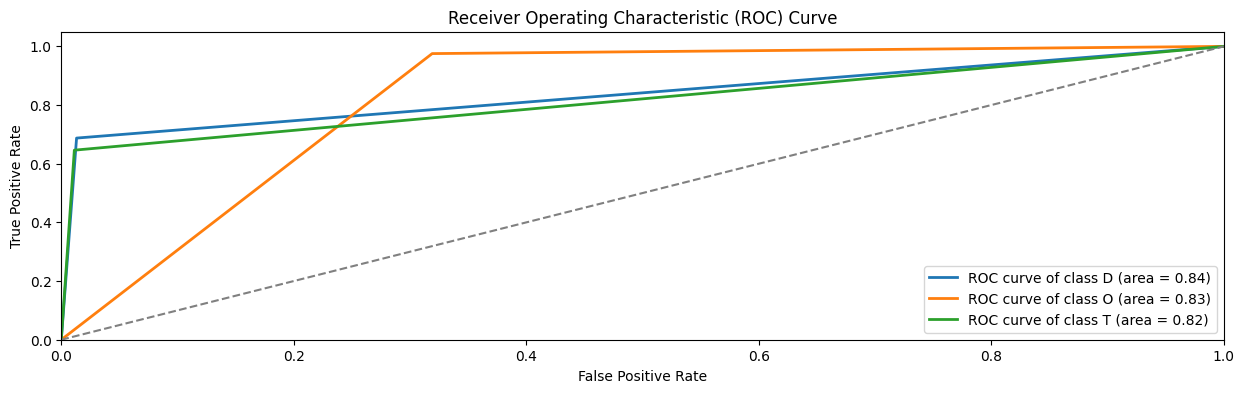

              precision    recall  f1-score   support

           D       0.82      0.69      0.75      1574
           O       0.95      0.98      0.96     16853
           T       0.78      0.65      0.71      1156

    accuracy                           0.93     19583
   macro avg       0.85      0.77      0.81     19583
weighted avg       0.93      0.93      0.93     19583



In [24]:
# Flatten the sequences (multi-label data)
Y_test_flat = [label for sublist in Y_test for label in sublist]
Y_pred_flat = [label for sublist in Y_pred for label in sublist]

# Use MultiLabelBinarizer to convert labels into binary format (one-hot encoding)
mlb = MultiLabelBinarizer()
Y_test_bin = mlb.fit_transform([[label] for label in Y_test_flat])
Y_pred_bin = mlb.transform([[label] for label in Y_pred_flat])

# Calculate ROC curve and AUC for each label
fpr, tpr, roc_auc = {}, {}, {}

# For each label
for i, label in enumerate(mlb.classes_):
    fpr[label], tpr[label], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[label] = auc(fpr[label], tpr[label])

# Plot ROC curve
plt.figure(figsize=(15, 4))

# Plot ROC curve for each label
for label in mlb.classes_:
    plt.plot(fpr[label], tpr[label], lw=2, label='ROC curve of class {0} (area = {1:0.2f})'.format(label, roc_auc[label]))

# Plot the diagonal line (chance level)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Optionally, print classification report
print(classification_report(Y_test_flat, Y_pred_flat))

<div style="background-color: #1c1c1c; color: white; padding: 20px; font-size: 16px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
  <h2>Extract Disease-Treatment Mappings</h2>
  <p>We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.</p>
  <p>Creating the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.
</p>
</div>

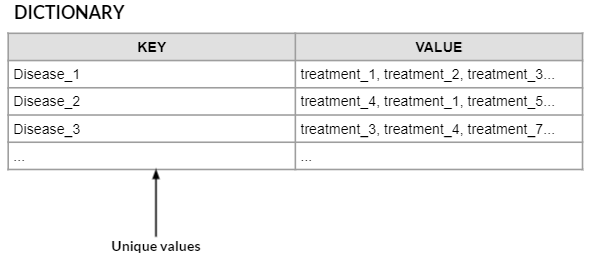

In [25]:
def get_labels_as_array(labels):
    """
    Flattens a list of lists into a single list.

    Parameters:
    labels (list of list): A list where each element is a list of labels.

    Returns:
    list: A single list containing all labels from the input lists.
    """
    pred_label = []  # Initialize an empty list to store all the labels

    # Loop through each list of labels in the input 'labels' list
    for label in labels:
        pred_label.extend(label)  # Add each element in the current list to 'pred_label'
        
    return pred_label  # Return the flattened list of labels

# Apply the function to 'Y_pred' and store the result in a new column 'pred_label' in the dataframe
test_frequency_df["pred_label"] = get_labels_as_array(Y_pred)

# Display the first 5 rows of the updated DataFrame to verify the new 'pred_label' column
test_frequency_df.head(5)

,sentence,text,lemma,pos,label,pred_label
0,test_1,Furthermore,furthermore,ADV,O,O
1,test_1,",",",",PUNCT,O,O
2,test_1,when,when,SCONJ,O,O
3,test_1,all,all,PRON,O,O
4,test_1,deliveries,delivery,NOUN,O,O


In [26]:
# Filter the rows where the 'pred_label' is not 'O' (i.e., labels that are not "O" - Other)
new_df = test_frequency_df[(test_frequency_df.pred_label != 'O')]

# Set 'sentence' column as the index for easier access to sentences
new_df.set_index('sentence', inplace=True)

# Initialize empty lists to store diseases, treatments, and sentences, and a dictionary for storing results
disease = []
treatment = []
sentence = []
med_dict = {}

# Loop through each unique sentence index in the filtered dataframe
for i in new_df.index.unique():
    try:
        # Get the unique 'pred_label' values for the current sentence
        val = new_df.loc[i, 'pred_label'].unique()
        
        # If both disease ('D') and treatment ('T') are present in the labels for this sentence
        if len(val) == 2:
            # Extract the text corresponding to the 'D' (disease) label
            disease_val = new_df[new_df.pred_label == 'D'].loc[i, 'text']
            
            # Extract the text corresponding to the 'T' (treatment) label
            treatment_val = new_df[new_df.pred_label == 'T'].loc[i, 'text']
            
            # If disease_val is a list, join it into a single string, otherwise, use it as is
            disease_single = disease_val if type(disease_val) == str else " ".join(disease_val)
            
            # If treatment_val is a list, join it into a single string, otherwise, use it as is
            treatment_single = treatment_val if type(treatment_val) == str else " ".join(treatment_val)
            
            # If the disease is not already in the dictionary, add it with its corresponding treatment
            if disease_single not in disease:
                med_dict[disease_single] = treatment_single
            else:
                # If the disease is already in the dictionary, append the new treatment to the existing one
                print('Entered')
                med_dict[disease_single] = med_dict.get(disease_single) + '/' + treatment_single
    except AttributeError:
        # Handle potential AttributeError if data is not as expected
        pass

# Convert the final dictionary to a JSON format and print it with proper indentation
print(json.dumps(dict((med_dict.items())), indent=4))

{
    "macrosomic infants in gestational diabetes cases": "good glycemic control",
    "retinoblastoma": "radiotherapy",
    "epilepsy ADHD": "Methylphenidate",
    "unstable angina or non - Q - wave myocardial infarction": "roxithromycin",
    "coronary - artery disease": "Antichlamydial antibiotics",
    "primary pulmonary hypertension ( PPH )": "fenfluramines",
    "essential hypertension": "moxonidine ` `",
    "foot infection in diabetic patients": "G - CSF treatment",
    "stroke hemorrhagic stroke": "double - bolus alteplase alteplase",
    "valvular heart diseasein cardiac disease": "fenfluramine - phentermine",
    "rheumatoid arthritis": "arthrodesis",
    "early Parkinson 's disease": "Ropinirole monotherapy",
    "sore throat": "antibiotics",
    "postoperative pain relief": "single - dose epidural fentanyl ( F )",
    "stress urinary incontinence": "surgery",
    "female stress urinary incontinence": "surgical treatment",
    "preeclampsia ( proteinuric hypertension": "int

<div style="background-color: #1c1c1c; color: white; padding: 20px; font-size: 16px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
  <h2>Evaluate the Model Performance</h2>
  <p>Predict the treatment for the disease name: 'hereditary retinoblastoma'</p>
</div>

In [27]:
# Initialize variables to store disease and treatment
disease = ''
treatment = ''

# Initialize lists to hold words, POS tags, and labels
input_text = []
input_pos = []
input_label = []

# Input sentence for processing
input_sent = 'hereditary retinoblastoma'

# Run the input sentence through the model to tokenize and label POS
input_model = model(input_sent)

# Loop through the model's output (tokens) and append details to the respective lists
for word in input_model:
    input_text.append(word.text)       # Append the token text
    input_pos.append(word.pos_)       # Append the POS tag
    input_label.append('D')            # Label all tokens as 'D' (Disease) for this example

# Create a DataFrame to store the token details (text, POS, and label)
details_sent = pd.DataFrame({'text': input_text, 'pos': input_pos, 'label': input_label})

# Apply 'get_word_details' function to each row to gather features
words_for_features = details_sent.apply(get_word_details, axis=1)

# Initialize list to hold the feature representation of each word in the sentence
test_sent = []

# Loop through each word in the sentence and extract its features
for i in range(len(input_sent.split())):
    test_sent.append(getFeaturesForOneWord(words_for_features, i))

# Predict the labels for each word using the CRF model
for i, tag in enumerate(crf.predict([test_sent])[0]):
    
    # If the predicted label is 'D' (Disease), process the corresponding word
    if tag == 'D':
        # Add the disease word (token) to the 'disease' string
        disease += input_sent.split()[i] + " "
        
        # Check if the disease is in the dictionary and append the corresponding treatment(s)
        if input_sent.split()[i] in med_dict:
            # Check if the treatment is already in the treatment string to avoid duplication
            treatment_value = med_dict.get(input_sent.split()[i])
            if treatment_value not in treatment:
                if len(treatment) > 0:
                    treatment += ", " + treatment_value
                else:
                    treatment += treatment_value

# Check if the entire disease (after joining words) is in the dictionary, and append treatment if present
if disease.strip() in med_dict:
    # Check if the treatment is already in the treatment string to avoid duplication
    treatment_value = med_dict.get(disease.strip())
    if treatment_value not in treatment:
        if len(treatment) > 0:
            treatment += ", " + treatment_value
        else:
            treatment += treatment_value

# Strip leading/trailing whitespace from the disease string
disease = disease.strip()

# If no treatment was found, set it to 'Not Available'
if len(treatment) == 0:
    treatment = 'Not Available'
else:
    # Remove the trailing comma and space if treatments were appended
    treatment = treatment.rstrip(", ")

# Print the identified disease and treatment
print('Identified Disease   :', disease)
print('Identified Treatment :', treatment)

Identified Disease   : retinoblastoma
Identified Treatment : radiotherapy


<div style="background-color: #1c1c1c; color: white; padding: 20px; font-size: 16px; border-radius: 10px; box-shadow: 0 4px 8px rgba(0, 0, 0, 0.2);">
  <h2>Conclusion</h2>
  <p>In this notebook, we successfully developed a custom Named Entity Recognition (NER) model to extract and classify diseases and their corresponding treatments from unstructured healthcare text data. Through data preprocessing, model training, and evaluation, we demonstrated the effectiveness of NER in structuring medical information that is otherwise difficult to analyze.</p>
  <p>Our approach involved cleaning and tokenizing medical text, annotating entities, and training an NER model capable of recognizing relevant terms with high accuracy. The results indicate that the model performs well in identifying disease-treatment relationships, highlighting its potential for assisting medical professionals, researchers, and automated healthcare systems.</p>
  <p>The structured output generated by the model enables better insights into medical records, facilitating improved decision-making and patient care. However, further refinements, such as expanding the dataset, incorporating domain-specific embeddings, and fine-tuning hyperparameters, could further enhance performance.</p>
  <p>Future work could explore integrating the model into real-world applications, such as clinical decision support systems or automated medical documentation tools, to optimize efficiency in healthcare data analysis. The successful implementation of this NER model underscores the value of natural language processing in the medical domain, paving the way for advancements in healthcare informatics.</p>
</div>